In [3]:
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [5]:
# Load preprocessed data
df = pd.read_csv("/content/sample_data/oral_cancer_prediction_preprocessed_dataset_new.csv")
print(df.head())




        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -0.699575  0.313334  0.560447 -0.336918 -1.106020 -0.598798 -1.297696   
1  0.673053 -0.184050  0.576740  1.757344  0.923448  0.746739  0.469264   
2  0.048024 -1.360864 -0.405148 -1.030663  0.777152 -0.456549 -1.895424   
3  1.604668  1.710142 -1.364305 -0.267710 -1.416786  0.038920  1.422042   
4 -2.382625 -1.884699 -0.133362  0.650046 -0.265694 -1.245969  1.377394   

        PC8       PC9      PC10      PC11      PC12      PC13      PC14  \
0 -0.724275 -1.637012 -0.821648 -0.459853 -1.457710 -1.369914 -0.223944   
1  1.723204  1.723343  0.136200 -0.024877 -1.790372 -1.337522 -0.206183   
2  1.622114 -1.418006  0.072663 -0.075828 -1.864626  0.332051  0.028287   
3  0.459523  0.031274 -0.796306 -0.435965 -0.193531  0.313675 -0.175422   
4  0.832647  1.254113  0.252565 -0.999554 -0.251933  0.640998  0.796805   

       PC15  Oral Cancer (Diagnosis)  
0 -0.056514                        0  
1 -0.059692         

In [6]:
# Features and target
X = df.drop("Oral Cancer (Diagnosis)", axis=1)  # all columns except target
y = df["Oral Cancer (Diagnosis)"]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Convert X_test to a DataFrame with feature names
X_test = pd.DataFrame(X_test, columns=X.columns)

In [9]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)

# Convert X_res to a DataFrame with feature names
X_res = pd.DataFrame(X_res, columns=X.columns)

print("Before SMOTE:", Counter(y_train))
print("After SMOTE:", Counter(y_res))

Before SMOTE: Counter({1: 34374, 0: 31798})
After SMOTE: Counter({0: 34374, 1: 34374})



Baseline Model Performance:
Accuracy: 0.5055914888472466
Precision: 0.52102942928631
Recall: 0.5125410220346929
F1 Score: 0.5167503692762186
AUC: 0.5053655054000702


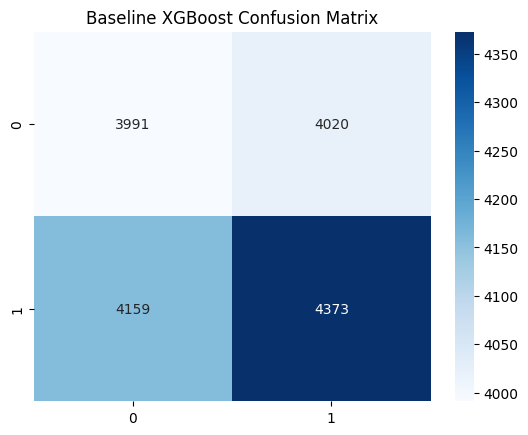

In [ ]:
# Baseline XGBoost
xgb_base = XGBClassifier(eval_metric='logloss', random_state=42)
xgb_base.fit(X_res, y_res)

# Predictions
y_pred_base = xgb_base.predict(X_test)

# Metrics
print("\nBaseline Model Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_base))
print("Precision:", precision_score(y_test, y_pred_base))
print("Recall:", recall_score(y_test, y_pred_base))
print("F1 Score:", f1_score(y_test, y_pred_base))
print("AUC:", roc_auc_score(y_test, y_pred_base))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_base)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Baseline XGBoost Confusion Matrix")
plt.show()


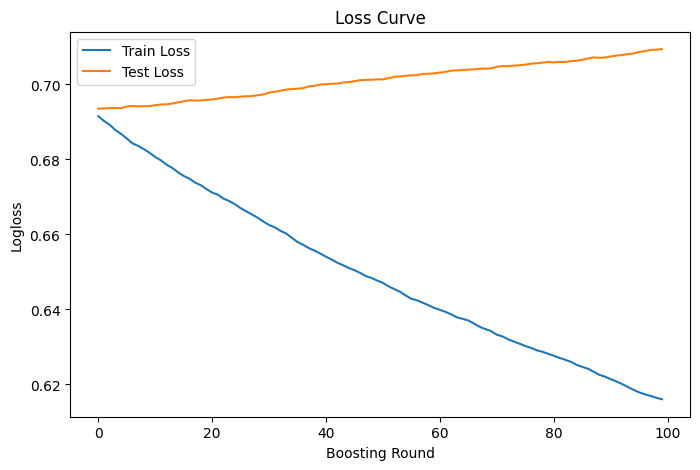

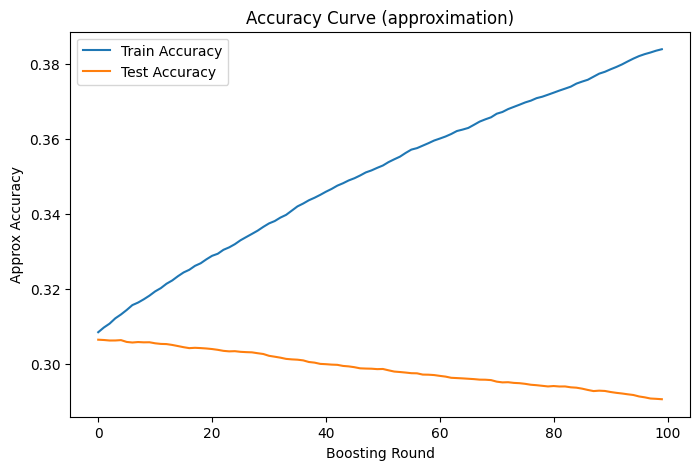

In [ ]:
xgb_eval = XGBClassifier(eval_metric='logloss', random_state=42)


xgb_eval.fit(
    X_res,
    y_res,
    eval_set=[(X_res, y_res), (X_test, y_test)],
    verbose=False
)


# Get loss per boosting round
results = xgb_eval.evals_result()

# Plot Loss Curve
plt.figure(figsize=(8,5))
plt.plot(results['validation_0']['logloss'], label='Train Loss')
plt.plot(results['validation_1']['logloss'], label='Test Loss')
plt.xlabel('Boosting Round')
plt.ylabel('Logloss')
plt.title('Loss Curve')
plt.legend()
plt.show()

# Plot Approximate Accuracy Curve (1 - logloss)
plt.figure(figsize=(8,5))
plt.plot([1-l for l in results['validation_0']['logloss']], label='Train Accuracy')
plt.plot([1-l for l in results['validation_1']['logloss']], label='Test Accuracy')
plt.xlabel('Boosting Round')
plt.ylabel('Approx Accuracy')
plt.title('Accuracy Curve (approximation)')
plt.legend()
plt.show()

/tmp/ipython-input-4115152220.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


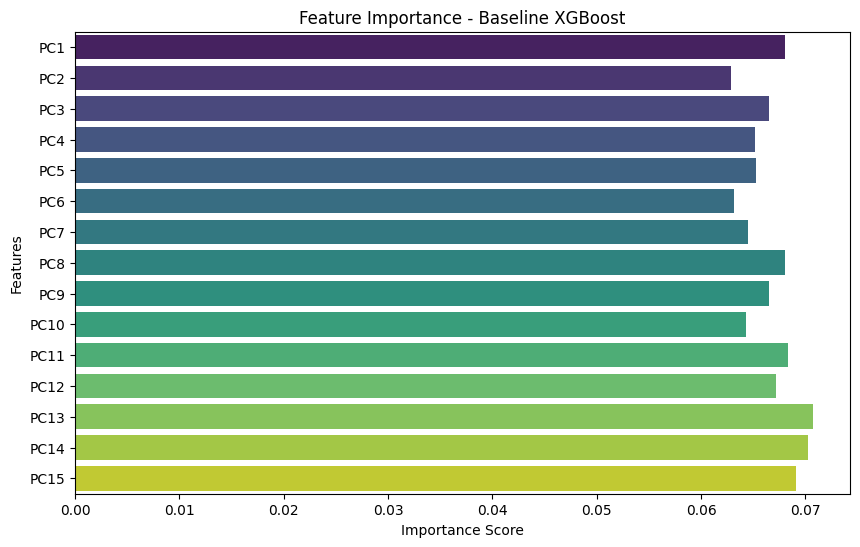

In [ ]:
# Feature Importance Plot
plt.figure(figsize=(10,6))
sns.barplot(
    x=xgb_base.feature_importances_,
    y=X.columns,
    palette='viridis'
)
plt.title("Feature Importance - Baseline XGBoost")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()



Manual Tuned Model Performance (5-Fold CV):
Accuracy: 0.505
F1 Score: 0.5068
Precision: 0.505
Recall: 0.5087
AUC: 0.505


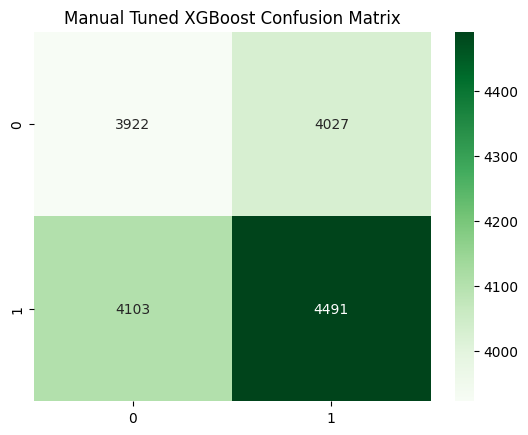

In [ ]:
from sklearn.model_selection import StratifiedKFold
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd # Import pandas

# 1. Define the model
manual = XGBClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    random_state=42
)

# Convert X_res and y_res back to DataFrames after SMOTE
X_res = pd.DataFrame(X_res, columns=X.columns)
y_res = pd.Series(y_res, name=y.name)


# 2. Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 3. Lists to store metrics for each fold
acc_list = []
f1_list = []
precision_list = []
recall_list = []
auc_list = []

# 4. Cross-validation
for train_index, val_index in skf.split(X_res, y_res):
    X_train_fold, X_val_fold = X_res.iloc[train_index], X_res.iloc[val_index]
    y_train_fold, y_val_fold = y_res.iloc[train_index], y_res.iloc[val_index]

    manual.fit(X_train_fold, y_train_fold)
    y_pred_fold = manual.predict(X_val_fold)

    acc_list.append(accuracy_score(y_val_fold, y_pred_fold))
    f1_list.append(f1_score(y_val_fold, y_pred_fold))
    precision_list.append(precision_score(y_val_fold, y_pred_fold))
    recall_list.append(recall_score(y_val_fold, y_pred_fold))
    auc_list.append(roc_auc_score(y_val_fold, y_pred_fold))

# 5. Average metrics across folds
print("\nManual Tuned Model Performance (5-Fold CV):")
print("Accuracy:", round(np.mean(acc_list), 4))
print("F1 Score:", round(np.mean(f1_list), 4))
print("Precision:", round(np.mean(precision_list), 4))
print("Recall:", round(np.mean(recall_list), 4))
print("AUC:", round(np.mean(auc_list), 4))


# 6. Train the model on the full resampled training data and predict on the test set for the confusion matrix
manual.fit(X_res, y_res)
y_pred_manual = manual.predict(X_test)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_manual)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.title("Manual Tuned XGBoost Confusion Matrix")
plt.show()

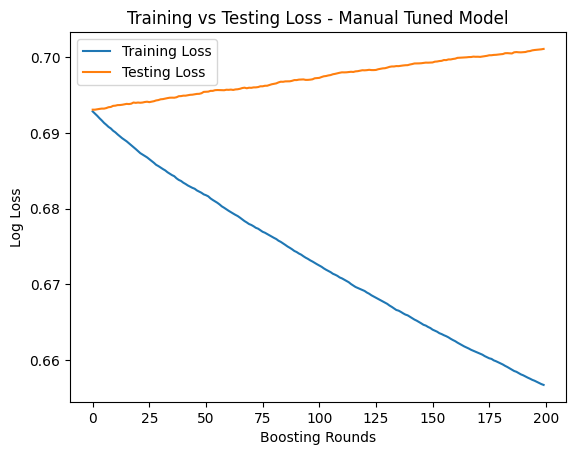

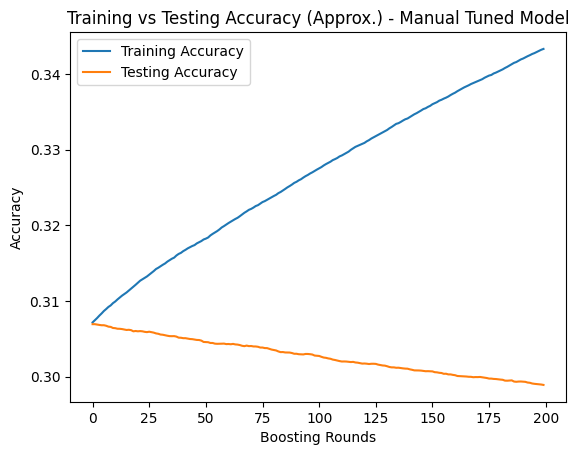

In [ ]:
# Convert X_test back to a DataFrame
X_test = pd.DataFrame(X_test, columns=X.columns)

# Train again with eval_set to track loss
eval_set = [(X_res, y_res), (X_test, y_test)]
manual.fit(X_res, y_res, eval_set=eval_set, verbose=False)

# Get training results
results = manual.evals_result()

# 1️⃣ Plot Training vs Testing Loss
plt.plot(results['validation_0']['logloss'], label='Training Loss')
plt.plot(results['validation_1']['logloss'], label='Testing Loss')
plt.title('Training vs Testing Loss - Manual Tuned Model')
plt.xlabel('Boosting Rounds')
plt.ylabel('Log Loss')
plt.legend()
plt.show()

# 2️⃣ Plot Approximate Training vs Testing Accuracy
train_acc = [1 - x for x in results['validation_0']['logloss']]
test_acc = [1 - x for x in results['validation_1']['logloss']]

plt.plot(train_acc, label='Training Accuracy')
plt.plot(test_acc, label='Testing Accuracy')
plt.title('Training vs Testing Accuracy (Approx.) - Manual Tuned Model')
plt.xlabel('Boosting Rounds')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [10:04:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best Hyperparameters (RandomizedSearchCV): {'subsample': 1.0, 'reg_lambda': 1, 'reg_alpha': 0, 'n_estimators': 400, 'max_depth': 6, 'learning_rate': 0.05, 'colsample_bytree': 0.8}

RandomizedSearchCV XGBoost Performance:
Accuracy: 0.5041
F1 Score: 0.5216
Precision: 0.5191
Recall: 0.5241
AUC: 0.5035


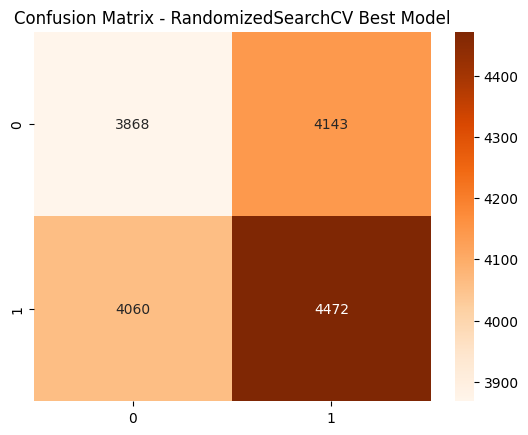

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

# Handle class imbalance
counter = Counter(y_res)
scale_pos_weight = counter[0] / counter[1]

# Base XGBoost
xgb_base = XGBClassifier(
    eval_metric='logloss',
    random_state=42,
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False
)

# Randomized hyperparameter grid (smaller and faster)
param_dist = {
    'n_estimators': [200, 300, 400],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.03, 0.05],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_lambda': [1, 2],
    'reg_alpha': [0, 0.5]
}

# Stratified 3-Fold
cv_strategy = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Randomized Search
rand_cv = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist,
    n_iter=20,   # 20 random combinations
    scoring='f1',
    cv=cv_strategy,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# Fit
rand_cv.fit(X_res, y_res)

# Best model
best_model = rand_cv.best_estimator_
print("Best Hyperparameters (RandomizedSearchCV):", rand_cv.best_params_)

# Predict
y_pred_rand= best_model.predict(X_test)

# Metrics
print("\nRandomizedSearchCV XGBoost Performance:")
print("Accuracy:", round(accuracy_score(y_test, y_pred_rand), 4))
print("F1 Score:", round(f1_score(y_test, y_pred_rand), 4))
print("Precision:", round(precision_score(y_test, y_pred_rand), 4))
print("Recall:", round(recall_score(y_test, y_pred_rand), 4))
print("AUC:", round(roc_auc_score(y_test, y_pred_rand), 4))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_rand)
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges')
plt.title("Confusion Matrix - RandomizedSearchCV Best Model")
plt.show()



/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [10:04:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


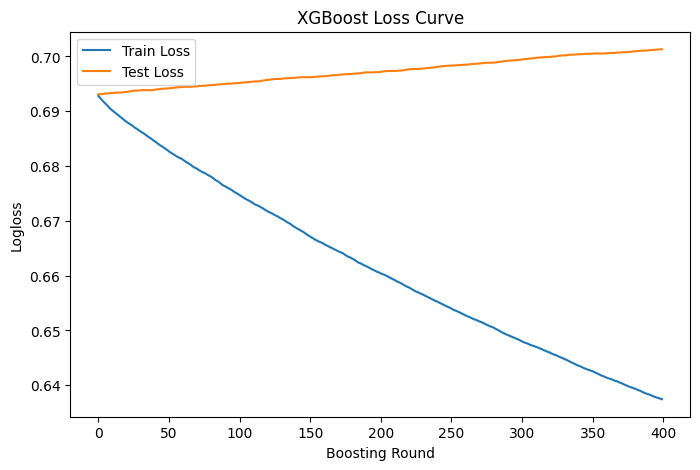

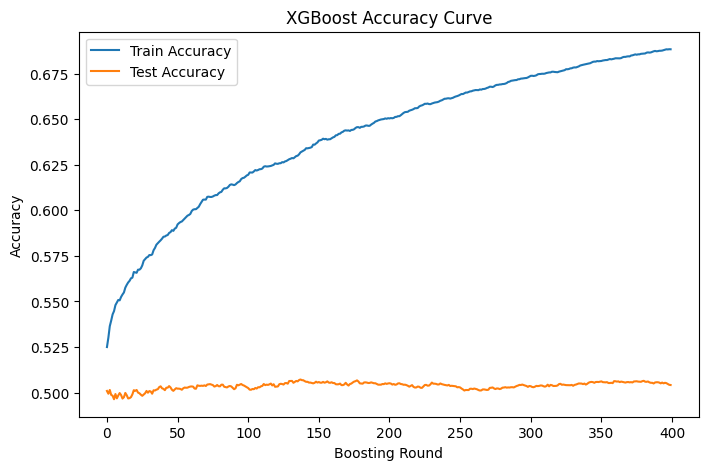

In [ ]:
# Retrain best model with eval set
eval_set = [(X_res, y_res), (X_test, y_test)]
best_model.fit(
    X_res, y_res,
    eval_set=eval_set,
    verbose=False
)

# Get logloss for train and test
results = best_model.evals_result()
train_loss = results['validation_0']['logloss']
test_loss = results['validation_1']['logloss']

# Plot Loss
plt.figure(figsize=(8,5))
plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Test Loss')
plt.xlabel('Boosting Round')
plt.ylabel('Logloss')
plt.title('XGBoost Loss Curve')
plt.legend()
plt.show()

# Accuracy per boosting round
train_acc = [accuracy_score(y_res, (best_model.predict_proba(X_res, iteration_range=(0,i+1))[:,1] > 0.5).astype(int)) for i in range(best_model.n_estimators)]
test_acc = [accuracy_score(y_test, (best_model.predict_proba(X_test, iteration_range=(0,i+1))[:,1] > 0.5).astype(int)) for i in range(best_model.n_estimators)]

# Plot Accuracy
plt.figure(figsize=(8,5))
plt.plot(train_acc, label='Train Accuracy')
plt.plot(test_acc, label='Test Accuracy')
plt.xlabel('Boosting Round')
plt.ylabel('Accuracy')
plt.title('XGBoost Accuracy Curve')
plt.legend()
plt.show()


Fitting 3 folds for each of 48 candidates, totalling 144 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [10:38:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best Hyperparameters: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1.0}

GridSearchCV Best Model Performance:
Accuracy: 0.5116
F1 Score: 0.542
Precision: 0.5284
Recall: 0.5562
AUC: 0.5098


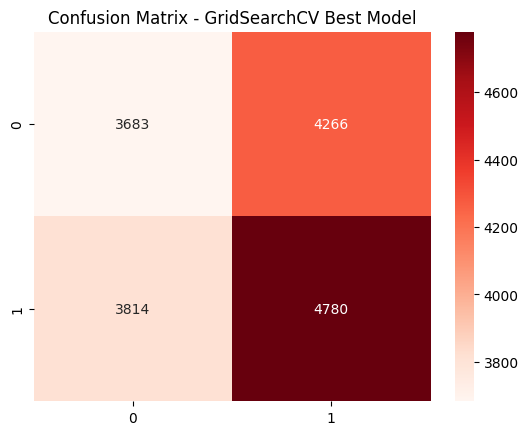

In [ ]:
# Handle class imbalance
counter = Counter(y_res)
scale_pos_weight = counter[0] / counter[1]

# Base XGBoost
xgb_grid = XGBClassifier(
    eval_metric='logloss',
    random_state=42,
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False
)

# Smaller parameter grid for faster execution
param_grid = {
    'n_estimators': [100, 200],       # fewer options
    'max_depth': [3, 4, 5],           # reasonable depths
    'learning_rate': [0.01, 0.05],    # small learning rates
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Stratified 3-Fold cross-validation
cv_strategy = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# GridSearchCV
grid_cv = GridSearchCV(
    estimator=xgb_grid,
    param_grid=param_grid,
    scoring='f1',       # we prioritize F1 because of class imbalance
    cv=cv_strategy,
    verbose=2,
    n_jobs=-1
)

# Fit GridSearchCV
grid_cv.fit(X_res, y_res)

# Best model
best_model = grid_cv.best_estimator_
print("Best Hyperparameters:", grid_cv.best_params_)

# Predictions
y_pred_grid = best_model.predict(X_test)

# Metrics
print("\nGridSearchCV Best Model Performance:")
print("Accuracy:", round(accuracy_score(y_test, y_pred_grid), 4))
print("F1 Score:", round(f1_score(y_test, y_pred_grid), 4))
print("Precision:", round(precision_score(y_test, y_pred_grid), 4))
print("Recall:", round(recall_score(y_test, y_pred_grid), 4))
print("AUC:", round(roc_auc_score(y_test, y_pred_grid), 4))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_grid)
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds')
plt.title("Confusion Matrix - GridSearchCV Best Model")
plt.show()

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [10:13:02] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


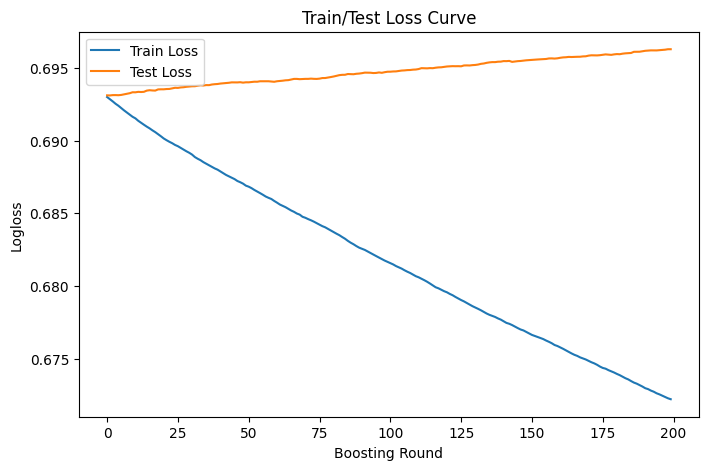

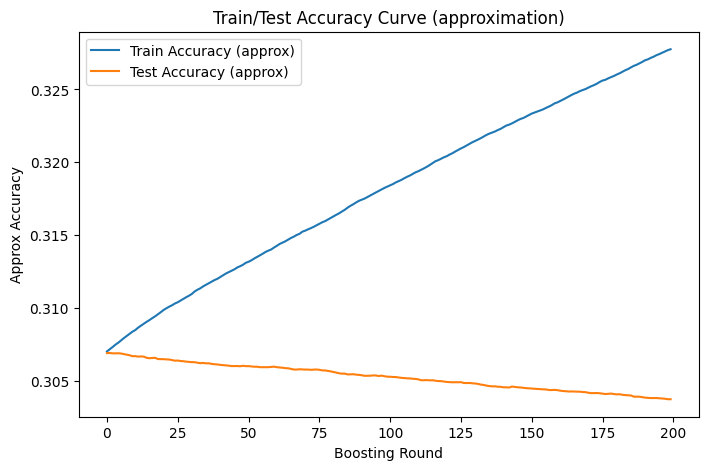

In [ ]:
# Prepare eval_set
eval_set = [(X_res, y_res), (X_test, y_test)]

# Refit the best model with eval_set
best_model.fit(
    X_res,
    y_res,
    eval_set=eval_set,
    verbose=False
)

# Get loss per boosting round
results = best_model.evals_result()

# Plot Loss Curve
plt.figure(figsize=(8,5))
plt.plot(results['validation_0']['logloss'], label='Train Loss')
plt.plot(results['validation_1']['logloss'], label='Test Loss')
plt.xlabel('Boosting Round')
plt.ylabel('Logloss')
plt.title('Train/Test Loss Curve')
plt.legend()
plt.show()

# Plot Approximate Accuracy Curve (1 - logloss)
plt.figure(figsize=(8,5))
plt.plot([1-l for l in results['validation_0']['logloss']], label='Train Accuracy (approx)')
plt.plot([1-l for l in results['validation_1']['logloss']], label='Test Accuracy (approx)')
plt.xlabel('Boosting Round')
plt.ylabel('Approx Accuracy')
plt.title('Train/Test Accuracy Curve (approximation)')
plt.legend()
plt.show()



Ensemble Model Performance:
Accuracy: 0.5145
F1 Score: 0.5402
Precision: 0.5317
Recall: 0.549
AUC: 0.5131


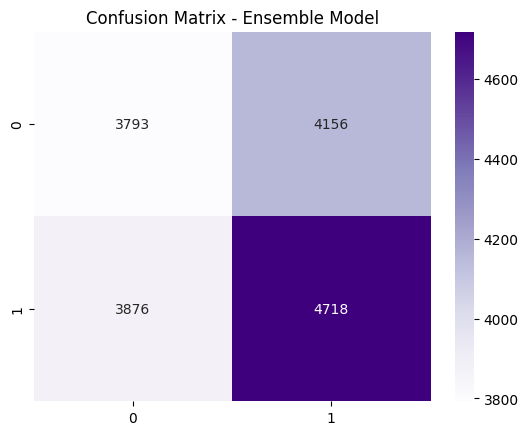

In [ ]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
import lightgbm as lgb

#1. Define individual models with reasonable hyperparameters
xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.01,
    subsample=1.0,
    colsample_bytree=1.0,
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)

rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

lgb_model = lgb.LGBMClassifier(
    n_estimators=200,
    max_depth=10,
    learning_rate=0.05,
    random_state=42
)

# 2. Create Voting Ensemble (soft voting for probabilities)
ensemble_model = VotingClassifier(
    estimators=[
        ('xgb', xgb_model),
        ('rf', rf_model),
        ('lgb', lgb_model)
    ],
    voting='soft',
    n_jobs=-1
)

# 3. Train ensemble on resampled training data
ensemble_model.fit(X_res, y_res)

# 4. Predict on test set
y_pred_ensemble = ensemble_model.predict(X_test)

# 5. Evaluate
print("\nEnsemble Model Performance:")
print("Accuracy:", round(accuracy_score(y_test, y_pred_ensemble), 4))
print("F1 Score:", round(f1_score(y_test, y_pred_ensemble), 4))
print("Precision:", round(precision_score(y_test, y_pred_ensemble), 4))
print("Recall:", round(recall_score(y_test, y_pred_ensemble), 4))
print("AUC:", round(roc_auc_score(y_test, y_pred_ensemble), 4))

# 6. Confusion Matrix
cm = confusion_matrix(y_test, y_pred_ensemble)
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples')
plt.title("Confusion Matrix - Ensemble Model")
plt.show()

/tmp/ipython-input-1838880478.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feat_importance.values, y=feat_importance.index, palette="viridis")


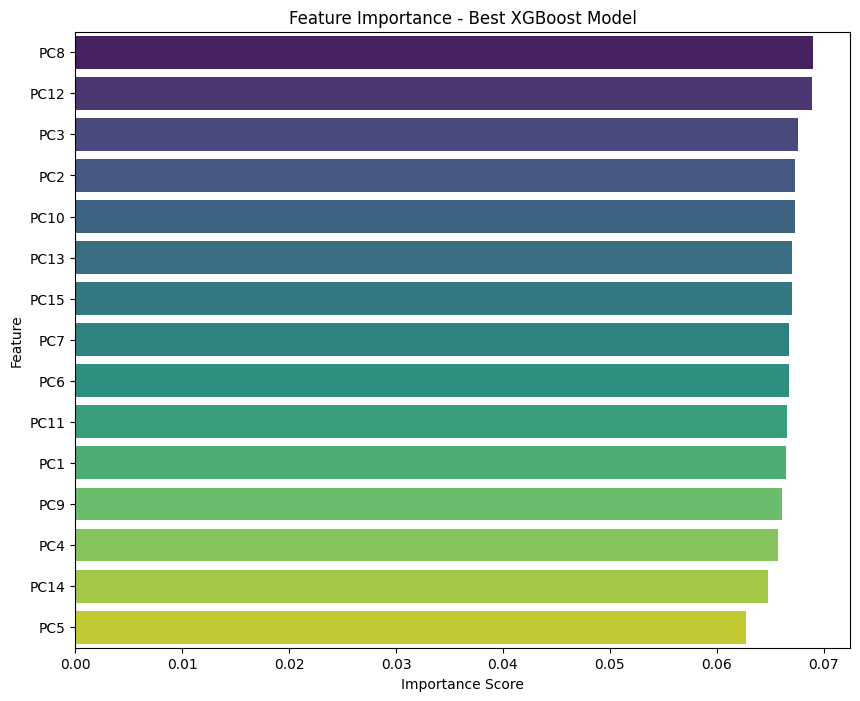

Removed low-importance features: []


In [ ]:
# Use best XGBoost (single tree model)
importances = best_model.feature_importances_
feat_importance = pd.Series(importances, index=X_res.columns).sort_values(ascending=False)

# Plot
plt.figure(figsize=(10,8))
sns.barplot(x=feat_importance.values, y=feat_importance.index, palette="viridis")
plt.title("Feature Importance - Best XGBoost Model")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

# Remove low importance features (<0.06)
low_importance_features = feat_importance[feat_importance < 0.06].index
X_res_reduced = X_res.drop(columns=low_importance_features)
X_test_reduced = X_test.drop(columns=low_importance_features)

print("Removed low-importance features:", list(low_importance_features))

In [ ]:
# 1. Prepare reduced feature sets
# ----------------------------
X_res_reduced = X_res.drop(columns=['PC5'])
X_test_reduced = X_test.drop(columns=['PC5'])


Ensemble Model Performance (Reduced Features):
Accuracy: 0.5101
F1 Score: 0.5357
Precision: 0.5276
Recall: 0.5441
AUC: 0.5087


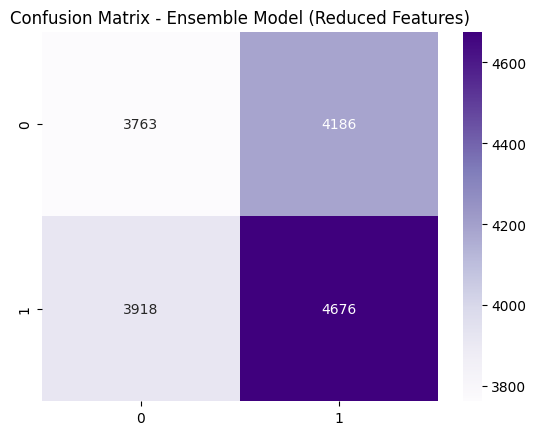

In [ ]:
# 1. Define individual models (same hyperparameters as before)
xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.01,
    subsample=1.0,
    colsample_bytree=1.0,
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)

rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

lgb_model = lgb.LGBMClassifier(
    n_estimators=200,
    max_depth=10,
    learning_rate=0.05,
    random_state=42
)

# 2. Create Voting Ensemble (soft voting)
ensemble_model = VotingClassifier(
    estimators=[('xgb', xgb_model), ('rf', rf_model), ('lgb', lgb_model)],
    voting='soft',
    n_jobs=-1
)

# 3. Train ensemble on reduced resampled training data
ensemble_model.fit(X_res_reduced, y_res)

# 4. Predict on reduced test set
y_pred_ensemble_reduced = ensemble_model.predict(X_test_reduced)

# 5. Evaluate
print("\nEnsemble Model Performance (Reduced Features):")
print("Accuracy:", round(accuracy_score(y_test, y_pred_ensemble_reduced), 4))
print("F1 Score:", round(f1_score(y_test, y_pred_ensemble_reduced), 4))
print("Precision:", round(precision_score(y_test, y_pred_ensemble_reduced), 4))
print("Recall:", round(recall_score(y_test, y_pred_ensemble_reduced), 4))
print("AUC:", round(roc_auc_score(y_test, y_pred_ensemble_reduced), 4))

# 6. Confusion Matrix
cm = confusion_matrix(y_test, y_pred_ensemble_reduced)
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples')
plt.title("Confusion Matrix - Ensemble Model (Reduced Features)")
plt.show()


Comparison of All Models:


,Accuracy,F1 Score,Precision,Recall,AUC
Baseline XGBoost,0.4964,0.5096,0.5157,0.5036,0.4961
Manual Tuned XGBoost,0.5086,0.5249,0.5272,0.5226,0.5080
RandomizedSearchCV XGBoost,0.5017,0.5210,0.5204,0.5216,0.5009
GridSearchCV XGBoost,0.5116,0.5420,0.5284,0.5562,0.5098
Ensemble Model,0.5145,0.5402,0.5317,0.5490,0.5131
Ensemble Reduced Features,0.5101,0.5357,0.5276,0.5441,0.5087


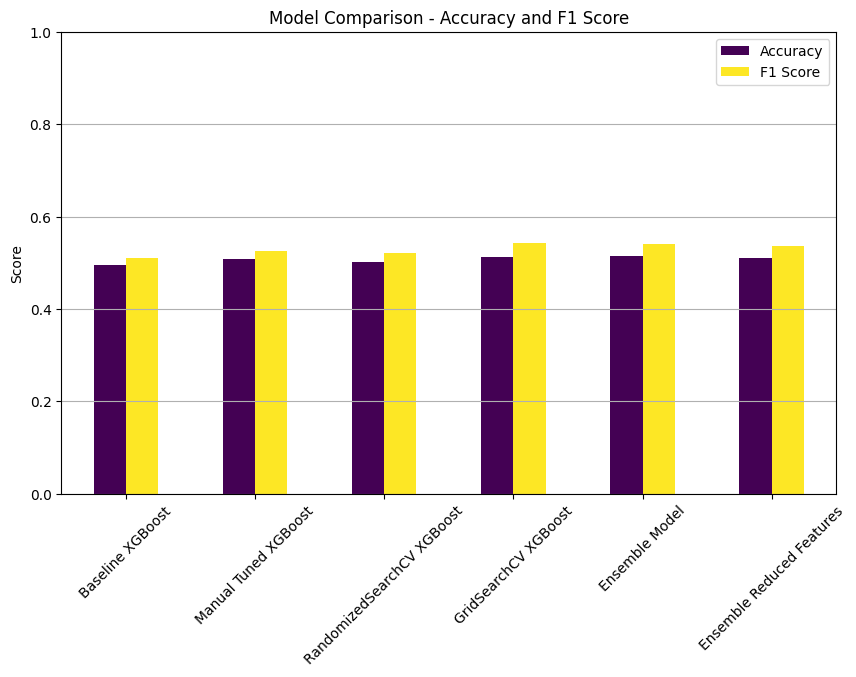

In [ ]:
# List of model names
model_names = [
    'Baseline XGBoost',
    'Manual Tuned XGBoost',
    'RandomizedSearchCV XGBoost',
    'GridSearchCV XGBoost',
    'Ensemble Model',
    'Ensemble Reduced Features'
]

# Corresponding predictions
predictions = [
    y_pred_base,
    y_pred_manual,
    y_pred_rand,              # RandomizedSearchCV predictions
    y_pred_grid,              # GridSearchCV predictions
    y_pred_ensemble,
    y_pred_ensemble_reduced
]

# Store metrics
metrics_list = []

for y_pred_model in predictions:
    metrics_list.append({
        'Accuracy': accuracy_score(y_test, y_pred_model),
        'F1 Score': f1_score(y_test, y_pred_model),
        'Precision': precision_score(y_test, y_pred_model),
        'Recall': recall_score(y_test, y_pred_model),
        'AUC': roc_auc_score(y_test, y_pred_model)
    })

# Create DataFrame
comparison_df = pd.DataFrame(metrics_list, index=model_names)
comparison_df = comparison_df.round(4)
print("\nComparison of All Models:")
display(comparison_df)

# Optional: plot Accuracy and F1 Score for visual comparison
comparison_df[['Accuracy','F1 Score']].plot(kind='bar', figsize=(10,6), rot=45, colormap='viridis')
plt.title("Model Comparison - Accuracy and F1 Score")
plt.ylabel("Score")
plt.ylim(0,1)
plt.grid(axis='y')
plt.show()

In [ ]:
# Compute combined score (average of Accuracy, F1 Score, and AUC)
comparison_df['Combined Score'] = comparison_df[['Accuracy','F1 Score','AUC']].mean(axis=1)

# Select best model based on combined score
best_idx = comparison_df['Combined Score'].idxmax()
best_model_metrics = comparison_df.loc[best_idx]

print(f"\nBest Model based on Combined Score: {best_idx}")
display(best_model_metrics)



Best Model based on Combined Score: Ensemble Model


,Ensemble Model
Accuracy,0.5145
F1 Score,0.5402
Precision,0.5317
Recall,0.5490
AUC,0.5131
Combined Score,0.5226
